In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import cv2
import os

In [2]:
# paths
base_path = 'E:/Data/Video_Frame_Interpolation/raw/240fps_horizontal'
base_path_2 = 'E:/Data/Video_Frame_Interpolation/raw/240fps_vertical'
target_path = 'E:/Data/Video_Frame_Interpolation/processed/med_motion'

# parameters
size = (224, 128)
fxy = None  #(1/10.0, 1/10.0)
interpolation = cv2.INTER_CUBIC
train2test_split = 0.8
train2valid_split = 0.9
is_horizontal = True
delay = 8

## Processing functions

In [3]:
def process_function(image, size, fxy, interpolation, is_horizontal=True):
    if not is_horizontal:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    if size is None:
        image = cv2.resize(image, (0, 0), fx=fxy[0], fy=fxy[1], interpolation=interpolation)
    else:
        image = cv2.resize(image, size, interpolation=interpolation)
        
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def read_opposite_frames(base_path, size=None, fxy=(1/8.0, 1/8.0), interpolation=cv2.INTER_CUBIC, is_horizontal=True, process_function=process_function, delay=1):
    assert (size is None and fxy is not None) or (size is not None and fxy is None)
    assert interpolation is not None
    assert os.path.exists(base_path)
    
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    
    data = []
    for video_filename in os.listdir(base_path):
        video_path = os.path.join(base_path, video_filename)
        if os.path.isfile(video_path):    
            # capture the video
            vidcap = cv2.VideoCapture(video_path)
            success, image = vidcap.read()
            
            # process captured frame
            image = process_function(image, size, fxy, interpolation, is_horizontal)
            
            # save frames in proper order
            first = image
            second = None
            third = None
            
            
            index = 1
            while success:
                # if each frame is setup then save it
                if first is not None and second is not None and third is not None:
                    data.append(np.array((first, second, third)))
                    
                    # restet the images state
                    first = None
                    second = None
                    third = None
                
                # read another frame to process
                success, image = vidcap.read()
                index += 1
                
                # break if the end of the video is reached
                if not success:
                    break
                  
                # apply the delay
                if index % delay != 0:
                    continue
                    
                # process each frame
                image = process_function(image, size, fxy, interpolation, is_horizontal)
                
                # replace the frames in the chain
                third = second
                second = first
                first = image

    return data

In [5]:
def split(data, train2test=0.8, train2valid=0.9):
    X = [[d[0], d[2]] for d in data]
    Y = [d[1] for d in data]
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train2test)    
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=train2valid)
    
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [6]:
def save_data(path, x_train, x_test, x_valid, y_train, y_test, y_valid):
    height, width, _ = y_train[0].shape
    creation_time = int(time.time())
    
    with open(os.path.join(path, f'x_train_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(x_train, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(os.path.join(path, f'y_train_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(y_train, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(os.path.join(path, f'x_test_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(x_test, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(os.path.join(path, f'y_test_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(y_test, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(os.path.join(path, f'x_valid_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(x_valid, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(os.path.join(path, f'y_valid_{height}x{width}_{creation_time}.pickle'), 'wb') as file:
        pickle.dump(y_valid, file, protocol=pickle.HIGHEST_PROTOCOL)

## Create dataset

In [7]:
data = read_opposite_frames(
    base_path,  
    size=size, 
    fxy=fxy, 
    interpolation=interpolation, 
    is_horizontal=is_horizontal,
    delay=delay
)

In [8]:
if base_path_2 is not None:
    data_2 = read_opposite_frames(
        base_path_2,  
        size=size, 
        fxy=fxy, 
        interpolation=interpolation, 
        is_horizontal=True,
        delay=delay
    )
    data.extend(data_2)
    data_2 = None

In [9]:
print(f'Loaded {len(data)} opposite frames in size {data[0][0].shape} each.')

Loaded 1277 opposite frames in size (128, 224, 3) each.


In [10]:
x_train, x_test, x_valid, y_train, y_test, y_valid = split(
    data,
    train2test=train2test_split,
    train2valid=train2valid_split
)

In [11]:
print(f'Train size: {len(x_train)}')
print(f'Test size: {len(x_test)}')
print(f'Validation size: {len(x_valid)}')

Train size: 918
Test size: 256
Validation size: 103


In [12]:
save_data(target_path, x_train, x_test, x_valid, y_train, y_test, y_valid)
print(f"Dataset was saved in {target_path}")

Dataset was saved in E:/Data/Video_Frame_Interpolation/processed/med_motion


## Visualize some data

In [13]:
def visualize_record(record):
    f, ax = plt.subplots(2, 3)
    f.set_size_inches(20, 10)
    
    r1_g = cv2.cvtColor(record[0], cv2.COLOR_RGB2GRAY)
    rd_g = cv2.cvtColor(record[1], cv2.COLOR_RGB2GRAY)
    r2_g = cv2.cvtColor(record[2], cv2.COLOR_RGB2GRAY)
    
    ax[0][0].set_title('First')
    ax[0][0].imshow(r1_g, 'gray')
    
    ax[0][1].set_title('Second')
    ax[0][1].imshow(rd_g, 'gray')

    ax[0][2].set_title('Third')
    ax[0][2].imshow(r2_g, 'gray')

    ft = cv2.GaussianBlur(r1_g, (3, 3), 1)
    ft = cv2.medianBlur(ft, 3)
    ft = cv2.Canny((ft*255).astype('uint8'), 50, 100)
    
    ax[1][0].set_title('First mdf')
    ax[1][0].imshow(ft, 'gray')

    tf = cv2.GaussianBlur(r2_g, (3, 3), 1)
    tf = cv2.medianBlur(tf, 3)
    tf = cv2.Canny((tf*255).astype('uint8'), 50, 100)
    
    ax[1][2].set_title('Second mdf')
    ax[1][2].imshow(tf, 'gray')

    tf = cv2.cvtColor(tf, cv2.COLOR_GRAY2RGB)
    ft = cv2.cvtColor(ft, cv2.COLOR_GRAY2RGB)
    
    tf[cv2.inRange(tf, (0, 0, 0), (0, 0, 0)) != 255] = (255.0, 0, 0)
    ft[cv2.inRange(ft, (0, 0, 0), (0, 0, 0)) != 255] = (0, 0, 255.0)
    
    ax[1][1].set_title('2 scales')
    ax[1][1].imshow(tf + ft)

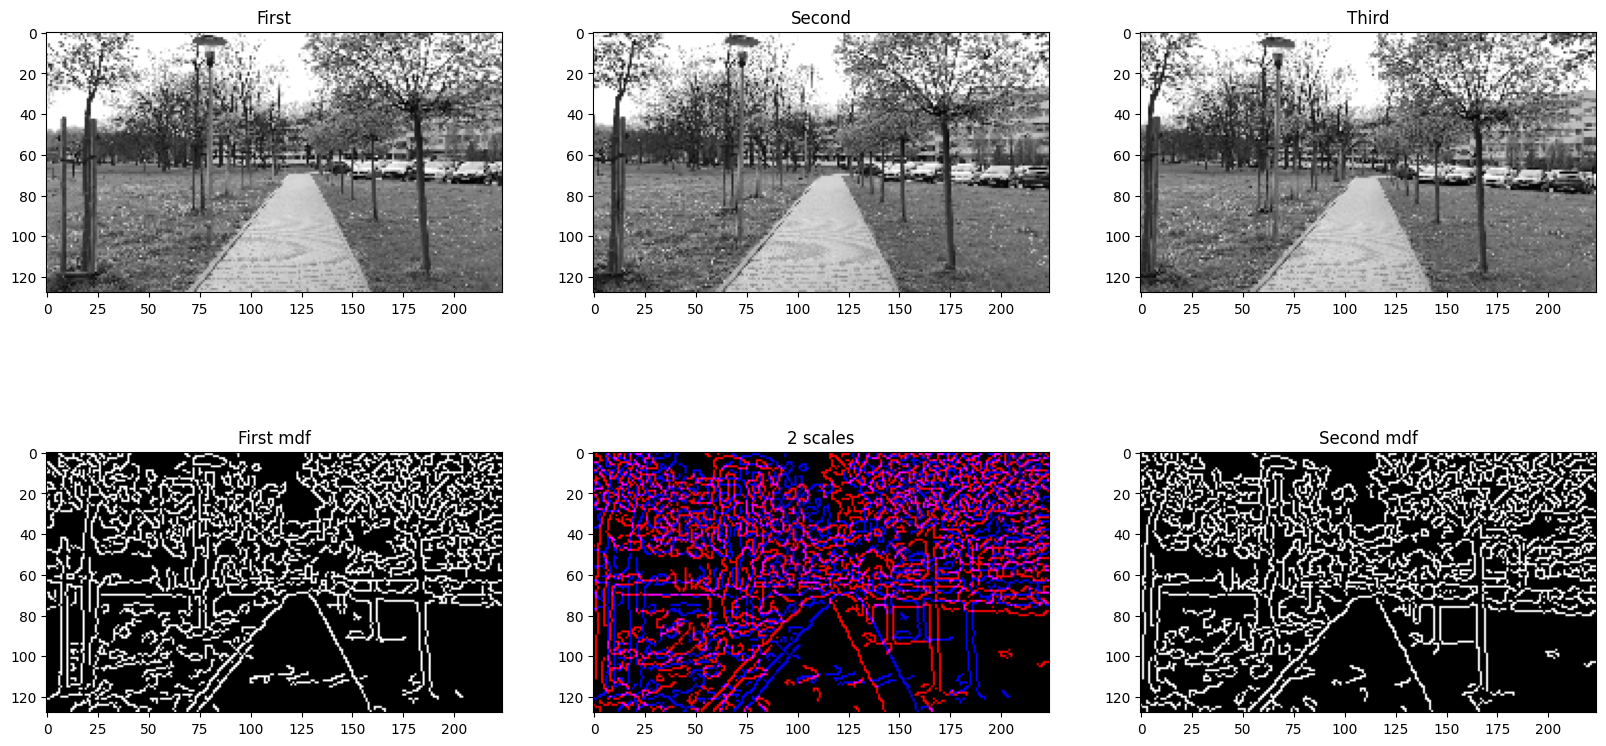

In [14]:
visualize_record(data[100])

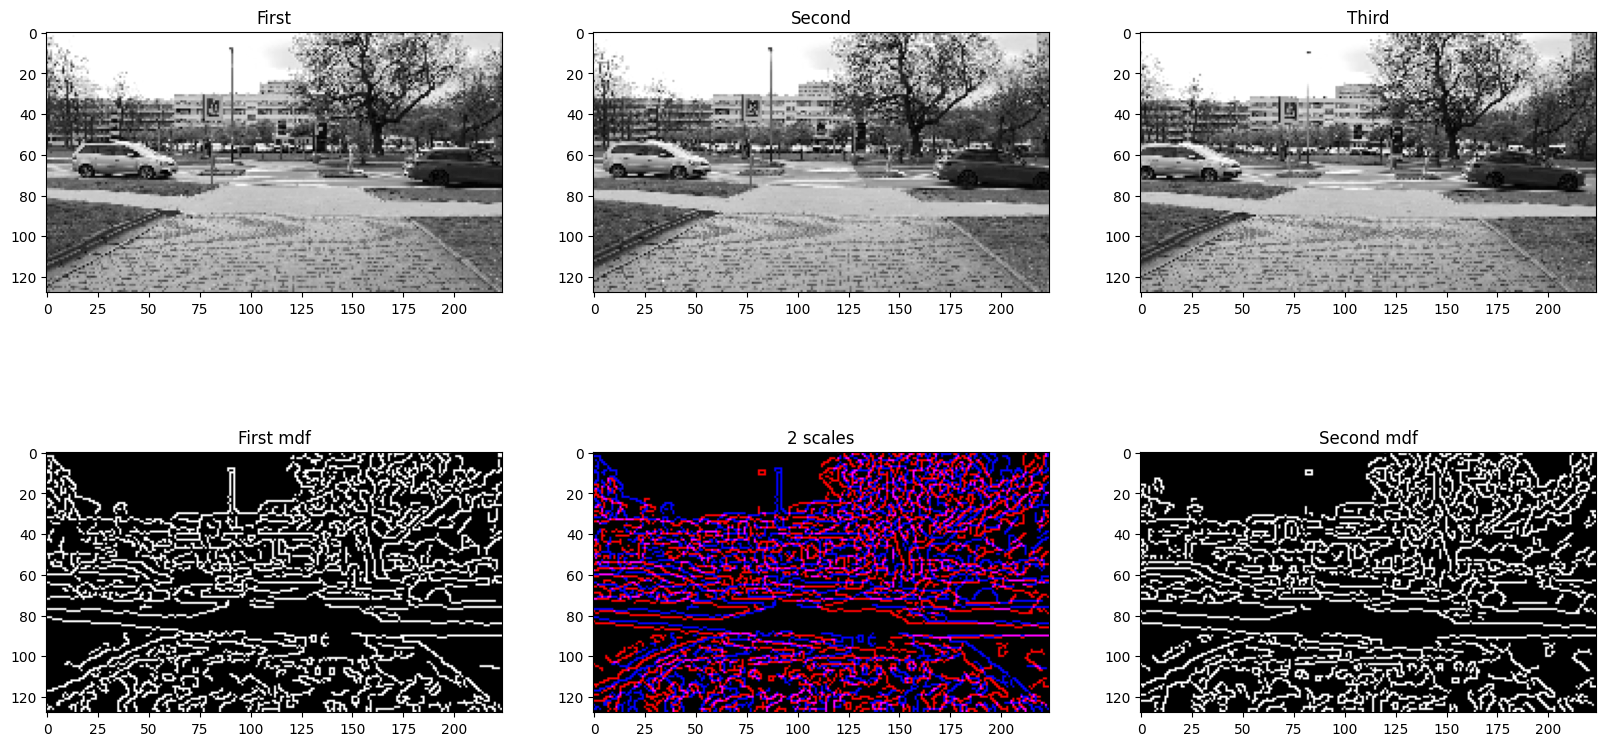

In [15]:
visualize_record(data[10])

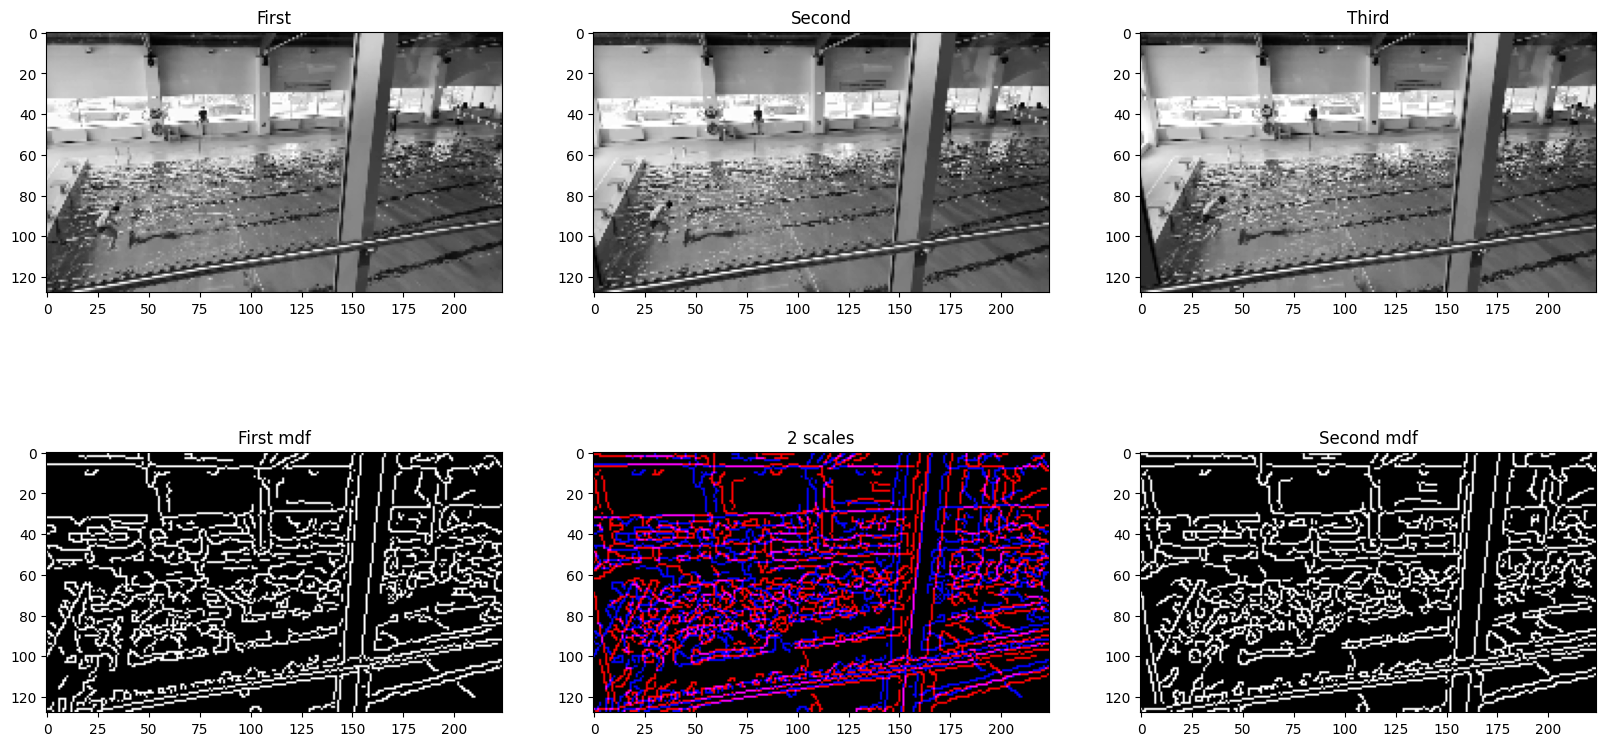

In [16]:
visualize_record(data[500])

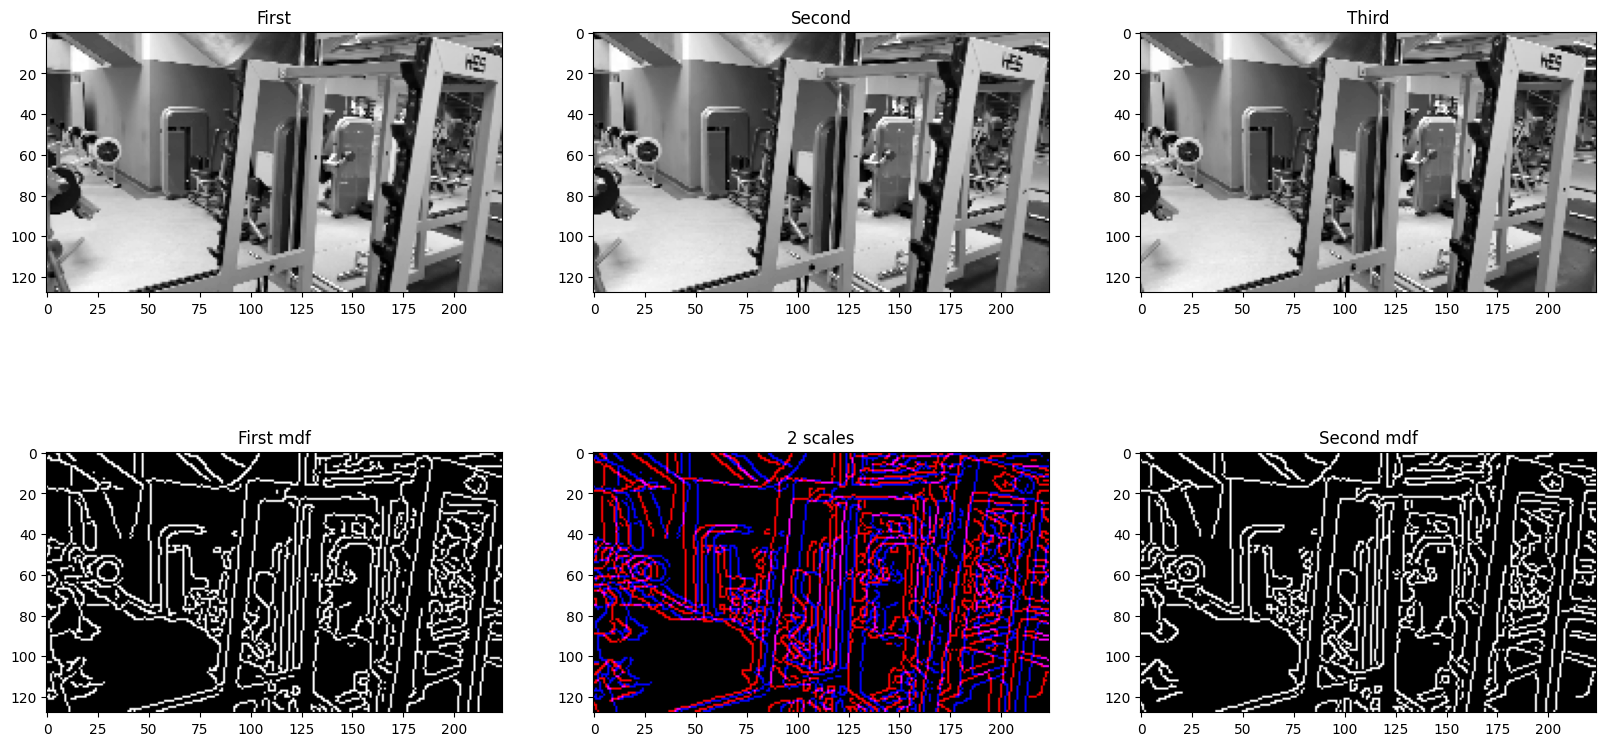

In [17]:
visualize_record(data[430])